<a id="top"></a>
# Landslide identification in Hong Kong using generative adversarial networks based on long term historical inventory data

**Author: Anran Zheng, Xiaoyi Wu**

**MUSA 650 Final Project**

This study applies a new proposed approach, which was based on the generative adversarial network (GAN), to landslide inventory data. GAN generate synthetic inventory data that makes up the shortage of original dataset. Based on fusing the original data and the synthetic data, prediction models were built, and the different types of landslide susceptibility were mapped. In this research, landslide inventory data was identified in Hong Kong, China, one most frequent landslide prone region. Based on previous studies and suggestions, multiple geo-environmental factors were compiled in the integration of geodatabase. The proposed model was compared with the traditional machine learning and deep learning models that have been commonly used in landslide susceptibility mapping, including K-nearest neighbors (KNN), Random Forest (RF), Decision Tree (DT) and Logistic Regression (LR) .  It is therefore necessary to explore how GAN improve and boost such models. Model performance was evaluated using the overall accuracy (OA), under the receiver operating characteristic curve (AUROC), confusion matrix and F1-score.  

## Contents

- Data process
    - [Data cleaning](#cleaning)
    - [Principal Component Analysis](#pca)
    
   
- Train the GAN model
    - [Train the GAN model](#gan)
    
    
- Assessment and comparison of models
    - [KNN](#knn)
    - [Logistic Regression](#lr)
    - [Decision Tree](#dt)
    - [Random Forest](#rf)
    
    
-  Landslide susceptibility mapping
    - [ Landslide susceptibility mapping](#mapping)

# 1. Data process


[Back to Top](#top)
<a id="cleaning"></a>
## 1.1 Data cleaning

load large landslide inventory dataset, which contains about 11,000 samples

In [254]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Dropout,Flatten,Conv2D, MaxPooling2D
import sys
from sklearn.preprocessing import StandardScaler

#GAN
from sdv.demo import load_tabular_demo
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
np.set_printoptions(threshold=sys.maxsize)

In [255]:
data_raw= pd.read_csv('..\\rawdata\\landslide3.csv')
data_raw.head()

,SLIDE_TYPE,M_WIDTH,S_LENGTH,SLOPE,COVER,YEAR_1,HEADELEV,TAILELEV,ELE_DIFF,GULLY,CLASS,curv_plan,curv_prof,aspect,curv,ID
0,R,14.0,8.0,9999.0,C,1967,9999.0,9999.0,9999.0,N,S,-9999.0,-9999.0,-9999.000,-9999.0,0
1,R,13.0,6.0,9999.0,C,1967,9999.0,9999.0,9999.0,N,S,-9999.0,-9999.0,-9999.000,-9999.0,1
2,R,15.0,13.5,9999.0,C,1967,9999.0,9999.0,9999.0,N,S,-9999.0,-9999.0,295.115,-9999.0,2
3,R,18.0,10.0,9999.0,C,1967,9999.0,9999.0,9999.0,N,S,-9999.0,-9999.0,150.945,-9999.0,3
4,R,17.0,10.0,9999.0,C,1967,9999.0,9999.0,9999.0,N,S,-9999.0,-9999.0,133.977,-9999.0,4


visualize the ```CLASS``` variable: there is lot of '-' meaning uncategorized landslide. We delete this later because this cause negative impact on model accuracy

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CLASS', ylabel='count'>

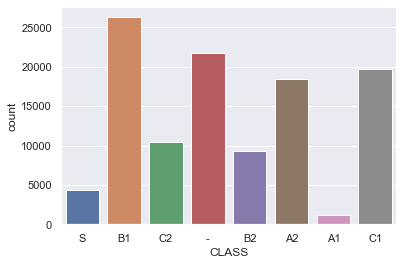

In [256]:

sns.countplot(data_raw['CLASS'] )

select 10000 data randomly

In [257]:
data=data_raw.sample(n=10000,random_state=1)

In [258]:
data.shape

(10000, 16)

delete abnormal values

C:\Users\zheng\AppData\Local\Temp/ipykernel_11876/3306246812.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['history']=2022-data1['YEAR_1']
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SLIDE_TYPE', ylabel='count'>

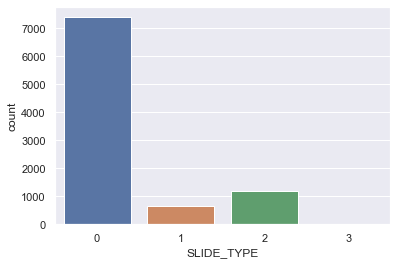

In [259]:

data1=data[~data['SLOPE'].isin([9999])]
data1=data[~data['HEADELEV'].isin([9999])]
data1=data[~data['TAILELEV'].isin([9999])]
data1=data[~data['ELE_DIFF'].isin([9999])]

#there is newly added data from GIS: curv_plan, curv_prof, aspect, curv
data1=data[~data['curv_plan'].isin([-9999])]
data1=data[~data['curv_prof'].isin([-9999])]
data1=data[~data['aspect'].isin([-9999])]
data1=data[~data['curv'].isin([-9999])]

data1['history']=2022-data1['YEAR_1']
data1=data1.drop(['YEAR_1','CLASS','ID'], axis=1)
#remove class
data2 = pd.get_dummies(data1, columns=['COVER','GULLY'])
#Y variable: SLIDE_TYPE
def slide_type(slide_type1):
    if slide_type1 == 'R':
        return 0
    elif slide_type1 == 'C':
        return 1
    elif slide_type1 == 'O':
        return 2
    else :
        return 3
    
data2['SLIDE_TYPE'] = data2['SLIDE_TYPE'].apply(slide_type)

#see the distribution of Y variable
sns.countplot(data2['SLIDE_TYPE'] )

In [260]:
data2.shape

(9240, 18)

In [261]:
col= data2.columns[pd.np.r_[1:18]]
x = np.array(data2[col])
y=np.array(data2['SLIDE_TYPE'])
# collect data with train data:test data is 3:7
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, stratify = y, random_state = 4)


C:\Users\zheng\AppData\Local\Temp/ipykernel_11876/3010493044.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  col= data2.columns[pd.np.r_[1:18]]


In [262]:
print(y.shape)
print(x.shape)
print(X_train.shape)
print(y_train.shape)

(9240,)
(9240, 17)
(6468, 17)
(6468,)


In [263]:
y_train[:5]

array([0, 0, 0, 0, 2], dtype=int64)

In [264]:
X_train[:5,:]

array([[ 1.10000e+01,  6.50000e+00,  2.95000e+01,  2.41000e+02,
         2.35000e+02,  6.00000e+00,  3.86668e-02, -5.96217e-02,
         1.62341e+02,  9.82885e-02,  5.90000e+01,  0.00000e+00,
         0.00000e+00,  1.00000e+00,  0.00000e+00,  1.00000e+00,
         0.00000e+00],
       [ 7.00000e+00,  8.00000e+00,  6.10000e+01,  5.13000e+02,
         5.01000e+02,  1.20000e+01, -3.72750e-01,  1.18693e-01,
         3.01087e+02, -4.91442e-01,  5.90000e+01,  0.00000e+00,
         0.00000e+00,  1.00000e+00,  0.00000e+00,  1.00000e+00,
         0.00000e+00],
       [ 1.00000e+01,  1.00000e+01,  3.35000e+01,  3.15000e+02,
         3.08000e+02,  7.00000e+00, -8.13650e-02, -4.45068e-02,
         3.18085e+02, -3.68582e-02,  5.90000e+01,  0.00000e+00,
         0.00000e+00,  1.00000e+00,  0.00000e+00,  1.00000e+00,
         0.00000e+00],
       [ 1.40000e+01,  1.10000e+01,  2.95000e+01,  1.55000e+02,
         1.48000e+02,  7.00000e+00,  6.58958e-02, -9.38230e-02,
         7.59464e+00,  1.59719e-01,

the input of gan in ```svd``` package is df, here convert the numpy into df

In [265]:
original_train=np.concatenate((y_train.reshape(-1,1),X_train),axis=1)
train_data=pd.DataFrame(data=original_train,columns=data2.columns[pd.np.r_[:18]])
train_data.head()

C:\Users\zheng\AppData\Local\Temp/ipykernel_11876/2506634044.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  train_data=pd.DataFrame(data=original_train,columns=data2.columns[pd.np.r_[:18]])


,SLIDE_TYPE,M_WIDTH,S_LENGTH,SLOPE,HEADELEV,TAILELEV,ELE_DIFF,curv_plan,curv_prof,aspect,curv,history,COVER_A,COVER_B,COVER_C,COVER_D,GULLY_N,GULLY_Y
0,0.0,11.0,6.5,29.5,241.0,235.0,6.0,0.038667,-0.059622,162.34100,0.098289,59.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,7.0,8.0,61.0,513.0,501.0,12.0,-0.372750,0.118693,301.08700,-0.491442,59.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,10.0,10.0,33.5,315.0,308.0,7.0,-0.081365,-0.044507,318.08500,-0.036858,59.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,14.0,11.0,29.5,155.0,148.0,7.0,0.065896,-0.093823,7.59464,0.159719,59.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2.0,6.5,3.0,20.0,364.0,361.0,3.0,-0.011728,0.197135,118.92100,-0.208863,23.0,1.0,0.0,0.0,0.0,1.0,0.0


[Back to Top](#top)
<a id="pca"></a>
## 1.2 Principal Component Analysis

PCA requires scaling/normalization of the data to work properly

In [346]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=None)
dfx = pd.DataFrame(data=x,columns=data2.columns[1:]) 
dfx_pca = pca.fit(dfx)

data2.columns[1:]

Index(['M_WIDTH', 'S_LENGTH', 'SLOPE', 'HEADELEV', 'TAILELEV', 'ELE_DIFF',
       'curv_plan', 'curv_prof', 'aspect', 'curv', 'history', 'COVER_A',
       'COVER_B', 'COVER_C', 'COVER_D', 'GULLY_N', 'GULLY_Y'],
      dtype='object')

In [347]:
dfx.head()

,M_WIDTH,S_LENGTH,SLOPE,HEADELEV,TAILELEV,ELE_DIFF,curv_plan,curv_prof,aspect,curv,history,COVER_A,COVER_B,COVER_C,COVER_D,GULLY_N,GULLY_Y
0,-0.343142,-0.528932,-0.182866,-0.131306,-0.130674,-0.200463,2.371016,-2.430549,0.348360,2.721795,0.370305,-0.471919,-0.173825,0.709346,-0.374967,0.178721,-0.178721
1,-0.509529,0.406550,-0.185367,-0.211413,-0.211764,-0.198886,-0.618278,0.517939,0.263299,-0.647116,0.370305,-0.471919,-0.173825,-1.409749,2.666904,0.178721,-0.178721
2,0.571985,1.903321,-0.190647,-0.208028,-0.208408,-0.198886,0.133016,-0.460818,0.264321,0.328097,0.370305,-0.471919,-0.173825,-1.409749,2.666904,0.178721,-0.178721
3,0.488792,0.219453,-0.190369,-0.256543,-0.255385,-0.199938,1.116044,0.454935,0.283347,0.416753,0.370305,-0.471919,-0.173825,-1.409749,2.666904,0.178721,-0.178721
4,1.237532,-0.435384,-0.182310,-0.297160,-0.296209,-0.199412,-0.069077,1.449178,-3.369837,-0.824429,0.370305,-0.471919,-0.173825,0.709346,-0.374967,0.178721,-0.178721


Plot the explained variance ratio

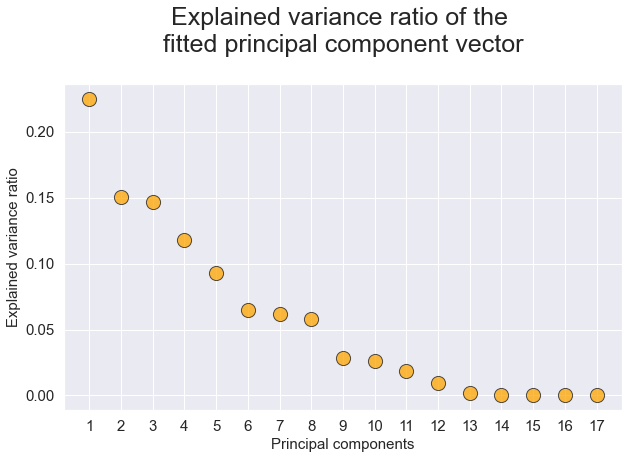

In [348]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

Showing better class separation using principal components

In [349]:
dfx_trans = pca.transform(dfx)
dfx_trans = pd.DataFrame(data=dfx_trans)
dfx_trans.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.155654,4.394332,0.454459,-0.035403,-0.940397,-0.364626,-0.196920,0.206928,0.065572,-0.075733,-0.097198,-0.017951,-0.024413,0.022378,5.770082e-06,1.664454e-16,-4.695335e-16
1,-0.396999,-1.029348,-0.168492,-0.603909,2.229982,-2.069486,-0.306575,-0.172004,-0.495523,0.047238,-0.206490,0.013552,0.018981,-0.017092,-2.335336e-08,1.664454e-16,5.782247e-17
2,-0.286981,0.540284,0.468846,-0.430768,3.409487,-0.992680,0.081924,0.242801,-0.775209,-0.057588,-0.115169,0.023231,0.010551,-0.013055,-5.530673e-07,3.052233e-16,5.782247e-17
3,-0.398832,0.626065,0.035166,-0.475603,2.578522,-1.716386,-0.255723,-0.030321,0.682409,0.897715,-0.199669,-0.009517,0.042701,-0.040376,2.242164e-08,1.386899e-16,5.782247e-17
4,-0.458021,-1.285294,1.210280,-0.079778,-0.177799,1.053051,1.262186,-2.979866,1.363848,0.609905,-0.152793,-0.032529,0.042881,-0.060860,-9.793621e-08,-3.331549e-16,5.574228e-16


Plot the first two columns of this transformed data set with the color set to original ground truth class label

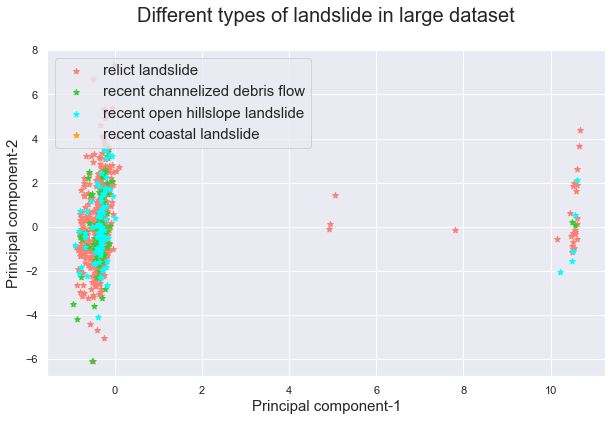

In [350]:
finalDf = pd.concat([dfx_trans, data2['SLIDE_TYPE']], axis = 1)

fig, ax = plt.subplots(figsize=(10,6))
x0 = finalDf[finalDf['SLIDE_TYPE']==0]
x1 = finalDf[finalDf['SLIDE_TYPE']==1]
x2 = finalDf[finalDf['SLIDE_TYPE']==2]
x3 = finalDf[finalDf['SLIDE_TYPE']==3]

plt.title("Different types of landslide in large dataset\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)

plt.scatter(x0[0], x0[1], c="salmon", marker='*', label='relict landslide')
plt.scatter(x1[0], x1[1], c="limegreen", marker='*', label='recent channelized debris flow')
plt.scatter(x2[0], x2[1], c="aqua", marker='*', label='recent open hillslope landslide')
plt.scatter(x3[0], x3[1], c="orange", marker='*', label='recent coastal landslide')

plt.legend(loc=2, prop = {'size':15})
ax.grid(True)

[Back to Top](#top)
<a id="gan"></a>
# 2. Train the GAN model 

we train gan model according to original train_data and tune the parameter according to ref doc: https://sdv.dev/SDV/user_guides/single_table/ctgan.html

In [268]:
#if you have GPU, cuda = True, else cuda = False 
model = CTGAN(cuda=True)

model.fit(train_data)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check f

In [269]:
original_train.shape

(6468, 18)

save and load the GAN model

In [270]:
# once you decide to use previous model, just load it, you don't need to train it again! 
model.save('new_trial\\my_model.pkl')

In [271]:
loaded = CTGAN.load('new_trial\\my_model.pkl')

generate new data, the original data: new data = 1:1 

In [272]:
new_data = loaded.sample(num_rows=train_data.shape[0])

In [273]:
new_data.shape

(6468, 18)

label ditribution in sythetic data and tune the parameter according to the this plot

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SLIDE_TYPE', ylabel='count'>

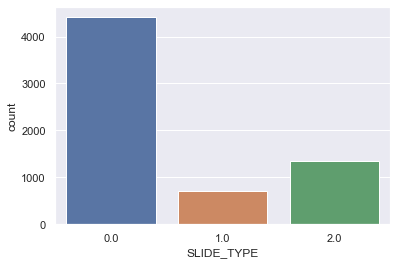

In [274]:
sns.countplot(new_data['SLIDE_TYPE'] )

evaluate the data generated from GAN (ref doc: https://sdv.dev/SDV/user_guides/evaluation/index.html#evaluation)

In [275]:
evaluate(new_data, train_data)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.5561425837996369

new train data: the mixture of original and generative data

In [276]:
new_train=pd.concat(
    [new_data, train_data],
    axis=0,
)
print(new_train.shape)
new_train.head()

(12936, 18)


,SLIDE_TYPE,M_WIDTH,S_LENGTH,SLOPE,HEADELEV,TAILELEV,ELE_DIFF,curv_plan,curv_prof,aspect,curv,history,COVER_A,COVER_B,COVER_C,COVER_D,GULLY_N,GULLY_Y
0,0.0,14.1,11.5,40.099376,117.618178,239.339120,17.698038,0.039447,-0.666617,132.348017,0.782715,59.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2.0,5.0,7.5,32.569109,6.000000,42.363364,3.758341,-0.060554,0.231533,163.118232,-0.372615,12.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2.0,15.6,12.2,5.584102,143.187310,298.095402,25.637841,-0.208149,-0.031540,155.269920,0.167968,59.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,17.0,12.0,62.551307,101.470194,186.429237,14.174436,0.440313,0.159996,300.435960,-0.397861,59.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2.0,17.2,6.2,44.001096,164.868862,44.290648,9999.000000,-0.032154,0.213527,153.568051,0.050475,51.0,1.0,0.0,0.0,0.0,1.0,0.0


In [277]:
#shuffle data
new_train_data = new_train.sample(frac=1).reset_index(drop=True)

In [278]:
# convert df to numpy for training input 
new_train_X=new_train_data.iloc[:,1:].values
new_train_Y_1=new_train_data.iloc[:,0:1].values
new_train_Y=np.squeeze(new_train_Y_1)

In [279]:
print(new_train_X.shape)
print(X_test.shape)
print(new_train_Y.shape)
print(y_test.shape)

(12936, 17)
(2772, 17)
(12936,)
(2772,)


do feature scaling first.

In [282]:
# data input of GAN model
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
#sc = MinMaxScaler()
new_train_X = sc.fit_transform(new_train_X)

In [283]:
# data input of model rather than GAN
sc = StandardScaler()
#sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# 3. Assessment and comparison of models

[Back to Top](#top)
<a id="knn"></a>
## 3.1 KNN

### 3.1.1 KNN & GAN

Hyperparameter(s):

- n_neighbors
- weights
- metric  

Hyperparameter optimization

In [312]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

#n_jobs=-1, accelerate running speed: https://scikit-learn.org/stable/computing/parallelism.html
model = KNeighborsClassifier(n_jobs=-1)

param_grid = { 
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=-1)

grid.fit(new_train_X, new_train_Y.ravel())

metric = grid.best_estimator_.metric
n_neighbors = grid.best_estimator_.n_neighbors
weights = grid.best_estimator_.weights

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.8840449124710462
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


In [313]:
knn = KNeighborsClassifier(metric=metric, n_neighbors=n_neighbors, weights=weights, n_jobs=8).fit(new_train_X, new_train_Y.ravel())
#Get predictions and probabilities on test set
knn_pred = knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)

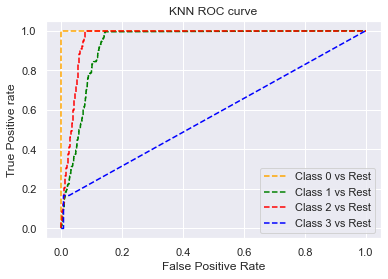

In [314]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, knn_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')

plt.title('KNN ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300);

In [315]:
knn_cls_precision, knn_cls_recall, knn_cls_f1, _ = precision_recall_fscore_support(y_test, knn_pred, average=None, labels=[0,1,2,3])
knn_conf_mat = confusion_matrix(y_test, knn_pred)
knn_acc = accuracy_score(y_test, knn_pred)
print('k Nearest Neighbors:')
print('Accuracy:',knn_acc)

k Nearest Neighbors:
Accuracy: 0.9278499278499278


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


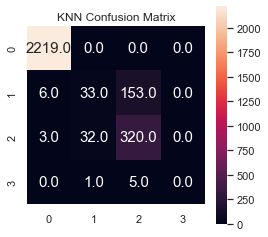

In [318]:
#Performance metrics
array = confusion_matrix(y_test, knn_pred)

knn_cm = pd.DataFrame(array, range(4), range(4))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(knn_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

plt.title('KNN Confusion Matrix')
plt.show()

In [332]:
for i in range(n_class): 
    print(i)
    print('Precision  = %.4f ' % (knn_cls_precision[i]))
    print('Recall on Y label = %.4f ' % (knn_cls_recall[i]))
    print('F1 on Y label = %.4f ' % (knn_cls_f1[i]))
    print('----------------------------')

0
Precision  = 0.9960 
Recall on Y label = 1.0000 
F1 on Y label = 0.9980 
----------------------------
1
Precision  = 0.5000 
Recall on Y label = 0.1719 
F1 on Y label = 0.2558 
----------------------------
2
Precision  = 0.6695 
Recall on Y label = 0.9014 
F1 on Y label = 0.7683 
----------------------------
3
Precision  = 0.0000 
Recall on Y label = 0.0000 
F1 on Y label = 0.0000 
----------------------------


### 3.1.2 original KNN model

In [356]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# todo: n_jobs=-1, accelerate running speed: https://scikit-learn.org/stable/computing/parallelism.html
model = KNeighborsClassifier(n_jobs=-1)

param_grid = { 
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=-1)

grid.fit(X_train, y_train.ravel())

metric = grid.best_estimator_.metric
n_neighbors = grid.best_estimator_.n_neighbors
weights = grid.best_estimator_.weights

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.9294979147018004
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


In [357]:
knn = KNeighborsClassifier(metric=metric, n_neighbors=n_neighbors, weights=weights, n_jobs=-1).fit(X_train, y_train.ravel())
knn_pred = knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)
knn_cls_precision, knn_cls_recall, knn_cls_f1, _ = precision_recall_fscore_support(y_test, knn_pred, average=None, labels=[0,1,2,3])

knn_conf_mat = confusion_matrix(y_test, knn_pred)
knn_acc = accuracy_score(y_test, knn_pred)
print('k Nearest Neighbors:')
print('Accuracy:',knn_acc)
#print('ROC AUC=%.4f' % (knn_roc_auc))

k Nearest Neighbors:
Accuracy: 0.9267676767676768


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


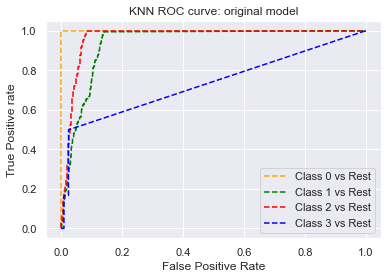

In [370]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, knn_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')

plt.title('KNN ROC curve: original model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300);

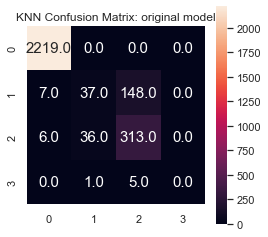

In [359]:
#Performance metrics
array = confusion_matrix(y_test, knn_pred)

knn_cm = pd.DataFrame(array, range(4), range(4))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(knn_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

plt.title('KNN Confusion Matrix: original model')
plt.show()

[Back to Top](#top)
<a id="lr"></a>
## 3.2. Logistic Regression

### 3.2.1 LR & GAN

Hyperparameter(s): C (inverse of regularization strength)

In [319]:
model = LogisticRegression(random_state=0, solver = 'liblinear')

param_grid={'C':np.logspace(-3,3,7), # inverse of regularization strength
     }

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(new_train_X, new_train_Y.ravel())

C = grid.best_estimator_.C

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.8866726032970703
Best hyperparameters: {'C': 100.0}


In [320]:
lr = LogisticRegression(random_state =0, solver = 'liblinear', C=C).fit(new_train_X, new_train_Y.ravel())
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)

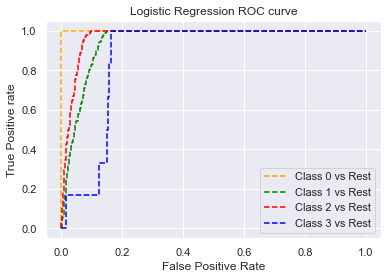

In [321]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, lr_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')

plt.title('Logistic Regression ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300);

In [322]:
lr_cls_precision, lr_cls_recall, lr_cls_f1, _ = precision_recall_fscore_support(y_test, lr_pred, average=None, labels=[0,1,2,3])
lr_conf_mat = confusion_matrix(y_test, lr_pred)
lr_acc = accuracy_score(y_test, lr_pred)
print('Logistic regression:')
print('Accuracy:',lr_acc)
#print('ROC AUC=%.4f' % (knn_roc_auc))

Logistic regression:
Accuracy: 0.9253246753246753


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


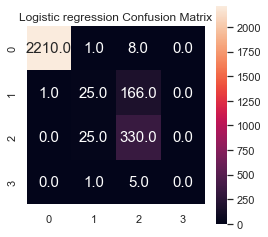

In [323]:
array = confusion_matrix(y_test, lr_pred)

lr_cm = pd.DataFrame(array, range(4), range(4))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(lr_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

plt.title('Logistic regression Confusion Matrix')
plt.show()

In [324]:
for i in range(n_class): 
    print(i)
    print('Precision  = %.4f ' % (lr_cls_precision[i]))
    print('Recall on Y label = %.4f ' % (lr_cls_recall[i]))
    print('F1 on Y label = %.4f ' % (lr_cls_f1[i]))
    print('----------------------------')

0
Precision  = 0.9995 
Recall on Y label = 0.9959 
F1 on Y label = 0.9977 
----------------------------
1
Precision  = 0.4808 
Recall on Y label = 0.1302 
F1 on Y label = 0.2049 
----------------------------
2
Precision  = 0.6483 
Recall on Y label = 0.9296 
F1 on Y label = 0.7639 
----------------------------
3
Precision  = 0.0000 
Recall on Y label = 0.0000 
F1 on Y label = 0.0000 
----------------------------


### 3.2.2 original LR model

In [360]:
model = LogisticRegression(random_state=0, solver = 'liblinear')

param_grid={'C':np.logspace(-3,3,7), # inverse of regularization strength
     }

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

C = grid.best_estimator_.C

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.93506349132351
Best hyperparameters: {'C': 1000.0}


In [361]:
lr = LogisticRegression(random_state =0, solver = 'liblinear', C=C).fit(X_train,y_train.ravel())
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)
lr_conf_mat = confusion_matrix(y_test, lr_pred)
lr_acc = accuracy_score(y_test, lr_pred)
print('Logistic Regression:')
print('Accuracy:',lr_acc)

Logistic Regression:
Accuracy: 0.9292929292929293


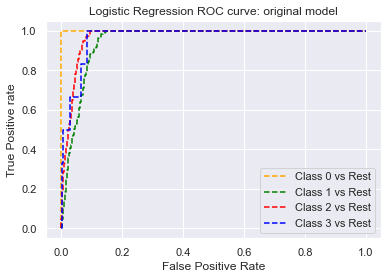

In [369]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, lr_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')

plt.title('Logistic Regression ROC curve: original model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300);

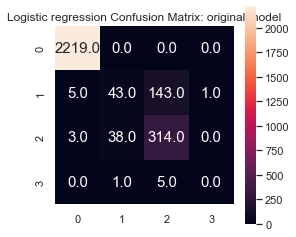

In [363]:
array = confusion_matrix(y_test, lr_pred)

lr_cm = pd.DataFrame(array, range(4), range(4))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(lr_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

plt.title('Logistic regression Confusion Matrix: original model')
plt.show()

[Back to Top](#top)
<a id="dt"></a>
## 3.3 Decision tree

### 3.3.1  DT & GAN

Hyperparameter optimization:  

- max_features
- max_depth
- criterion

In [325]:
model = DecisionTreeClassifier(random_state=0)

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,40,5),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(new_train_X, new_train_Y.ravel())

criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.8780922804487303
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto'}


In [334]:
dt = DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth=max_depth, max_features=max_features).fit(new_train_X, new_train_Y.ravel())
dt_pred = dt.predict(X_test)
dt_proba = dt.predict_proba(X_test)

dt_cls_precision, dt_cls_recall, dt_cls_f1, _ = precision_recall_fscore_support(y_test, dt_pred, average=None, labels=[0,1,2,3])
dt_conf_mat = confusion_matrix(y_test, dt_pred)
dt_acc = accuracy_score(y_test, dt_pred)
print('Decision Tree:')
print('Accuracy:',dt_acc)

Decision Tree:
Accuracy: 0.9238816738816739


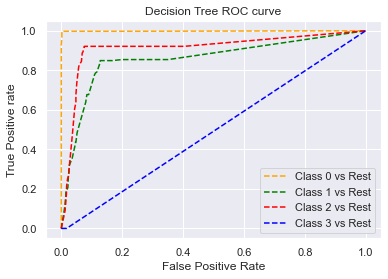

In [335]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, dt_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')

plt.title('Decision Tree ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300);

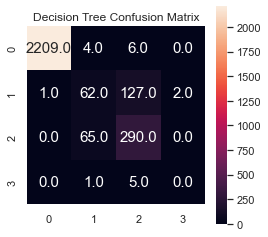

In [336]:
array = confusion_matrix(y_test, dt_pred)

dt_cm = pd.DataFrame(array, range(4), range(4))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(dt_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

plt.title('Decision Tree Confusion Matrix')
plt.show()

In [337]:
for i in range(n_class): 
    print(i)
    print('Precision  = %.4f ' % (dt_cls_precision[i]))
    print('Recall on Y label = %.4f ' % (dt_cls_recall[i]))
    print('F1 on Y label = %.4f ' % (dt_cls_f1[i]))
    print('----------------------------')

0
Precision  = 0.9995 
Recall on Y label = 0.9955 
F1 on Y label = 0.9975 
----------------------------
1
Precision  = 0.4697 
Recall on Y label = 0.3229 
F1 on Y label = 0.3827 
----------------------------
2
Precision  = 0.6776 
Recall on Y label = 0.8169 
F1 on Y label = 0.7407 
----------------------------
3
Precision  = 0.0000 
Recall on Y label = 0.0000 
F1 on Y label = 0.0000 
----------------------------


### 3.3.2 original DT model 

In [364]:
model = DecisionTreeClassifier(random_state=0)

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,40,5),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.9363016408649116
Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto'}


In [365]:
dt = DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth=max_depth, max_features=max_features).fit(X_train, y_train.ravel())
dt_pred = dt.predict(X_test)
dt_proba = dt.predict_proba(X_test)

dt_conf_mat = confusion_matrix(y_test, dt_pred)
dt_acc = accuracy_score(y_test, dt_pred)
print('Decision Tree:')
print('Accuracy:',dt_acc)

Decision Tree:
Accuracy: 0.9264069264069265


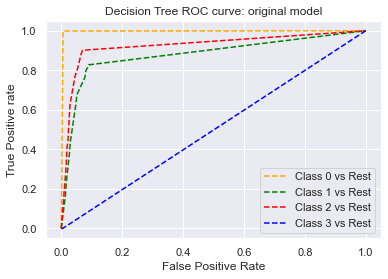

In [368]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, dt_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')

plt.title('Decision Tree ROC curve: original model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300);

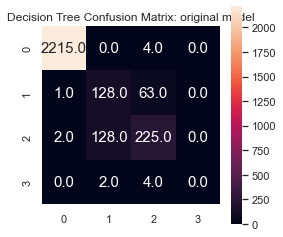

In [367]:
array = confusion_matrix(y_test, dt_pred)

dt_cm = pd.DataFrame(array, range(4), range(4))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(dt_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

plt.title('Decision Tree Confusion Matrix: original model')
plt.show()

# 3.4 Random forest

Hyperparameter(s):

- n_estimators
- max_features
- max_depth
- criterion

### 3.4.1 RF & GAN

In [304]:
#Hyperparameter optimization
model = RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,30,2),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(new_train_X, new_train_Y.ravel())

n_estimators = grid.best_estimator_.n_estimators
criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.8942484387219656
Best hyperparameters: {'criterion': 'gini', 'max_depth': 28, 'max_features': 'auto', 'n_estimators': 300}


<BarContainer object of 17 artists>

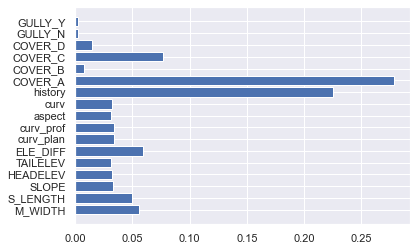

In [305]:
rf = RandomForestClassifier(random_state=0, criterion=criterion, max_depth=max_depth, max_features=max_features, n_estimators = n_estimators).fit(new_train_X, new_train_Y.ravel())
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

plt.barh(new_train_data.iloc[:,1:].columns,rf.feature_importances_)

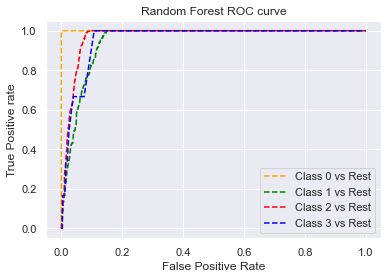

In [309]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, rf_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')

plt.title('Random Forest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300);

In [310]:
rf_cls_precision, rf_cls_recall, rf_cls_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average=None, labels=[0,1,2,3])

rf_conf_mat = confusion_matrix(y_test, rf_pred)
rf_acc = accuracy_score(y_test, rf_pred)
print('Random Forest:')
print('Accuracy:',rf_acc)

Random Forest:
Accuracy: 0.9303751803751804


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


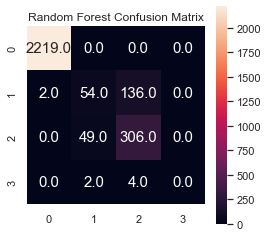

In [340]:
array = confusion_matrix(y_test, rf_pred)

rf_cm = pd.DataFrame(array, range(4), range(4))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(rf_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

plt.title('Random Forest Confusion Matrix')
plt.show()

In [341]:
for i in range(n_class): 
    print(i)
    print('Precision  = %.4f ' % (rf_cls_precision[i]))
    print('Recall on Y label = %.4f ' % (rf_cls_recall[i]))
    print('F1 on Y label = %.4f ' % (rf_cls_f1[i]))
    print('----------------------------')

0
Precision  = 0.9991 
Recall on Y label = 1.0000 
F1 on Y label = 0.9995 
----------------------------
1
Precision  = 0.5143 
Recall on Y label = 0.2812 
F1 on Y label = 0.3636 
----------------------------
2
Precision  = 0.6861 
Recall on Y label = 0.8620 
F1 on Y label = 0.7640 
----------------------------
3
Precision  = 0.0000 
Recall on Y label = 0.0000 
F1 on Y label = 0.0000 
----------------------------


[Back to Top](#top)
<a id="rf"></a>
### 3.4.2 original RF model

In [342]:
model = RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,30,2),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

n_estimators = grid.best_estimator_.n_estimators
criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.9503705005313356
Best hyperparameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 500}


In [343]:

rf = RandomForestClassifier(random_state=0, criterion=criterion, max_depth=max_depth, max_features=max_features, n_estimators = n_estimators).fit(X_train,y_train.ravel())

rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)
rf_cls_precision, rf_cls_recall, rf_cls_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average=None, labels=[0,1,2,3])
rf_conf_mat = confusion_matrix(y_test, rf_pred)
rf_acc = accuracy_score(y_test, rf_pred)
print('Random Forest:')
print('Accuracy:',rf_acc)

Random Forest:
Accuracy: 0.9383116883116883


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


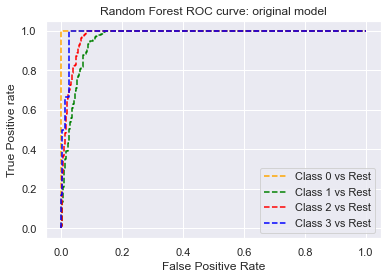

In [371]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, rf_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='Class 3 vs Rest')

plt.title('Random Forest ROC curve: original model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300);

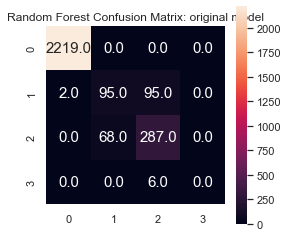

In [372]:
array = confusion_matrix(y_test, rf_pred)

rf_cm = pd.DataFrame(array, range(4), range(4))

plt.figure(figsize=(4,4))
sns.set(font_scale=1) # for label size
sns.heatmap(rf_cm, annot=True, annot_kws={"size": 15}, cbar=True, square= True, fmt='.1f') # font size

plt.title('Random Forest Confusion Matrix: original model')
plt.show()

[Back to Top](#top)
<a id="mapping"></a>
# 4. Landslide susceptibility mapping

In [351]:
#create dataset for landslide mapping
data1=data[~data['SLOPE'].isin([9999])]
data1=data[~data['HEADELEV'].isin([9999])]
data1=data[~data['TAILELEV'].isin([9999])]
data1=data[~data['ELE_DIFF'].isin([9999])]

#newly added data: curv_plan, curv_prof, aspect, curv
data1=data[~data['curv_plan'].isin([-9999])]
data1=data[~data['curv_prof'].isin([-9999])]
data1=data[~data['aspect'].isin([-9999])]
data1=data[~data['curv'].isin([-9999])]

data1['history']=2022-data1['YEAR_1']

data1.to_csv('../save_data/data_mapping.csv')

C:\Users\zheng\AppData\Local\Temp/ipykernel_11876/393882748.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['history']=2022-data1['YEAR_1']


predict the landslide with logistic regression model

In [353]:
lr_pred_all=lr.predict(x)
lr_pred_all1=pd.DataFrame(lr_pred_all, columns = ['predict'])
finalDf1 = pd.concat([data1, lr_pred_all1], axis = 1)
#save the predict values in csv
finalDf1.to_csv('../save_data/data_mapping2.csv')
#next do the mapping in ArcGIS, join this table with the landslide point dataset layer and please see the results in report